<a href="https://colab.research.google.com/github/Rtrey29/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/LS_DS_142_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [3]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [4]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=29.957001202173373, pvalue=3.12550243627164e-07)


In [5]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [6]:
import pandas as pd
import numpy as np
from scipy import stats

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values = ' ?')
print(df.shape)
df.head(20)

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [7]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
country            583
salary               0
dtype: int64

In [8]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [9]:
df.describe(exclude='number')

,workclass,education,marital-status,occupation,relationship,race,sex,country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [10]:
df['hours-per-week']

0        40
1        13
2        40
3        40
4        40
5        40
6        16
7        45
8        50
9        40
10       80
11       40
12       30
13       50
14       40
15       45
16       35
17       40
18       50
19       45
20       60
21       20
22       40
23       40
24       40
25       40
26       40
27       60
28       80
29       40
         ..
32531    99
32532    60
32533    50
32534    39
32535    35
32536    55
32537    46
32538    45
32539    10
32540    40
32541    32
32542    25
32543    48
32544    30
32545    20
32546    40
32547    40
32548    60
32549    40
32550    50
32551    40
32552    45
32553    11
32554    40
32555    40
32556    38
32557    40
32558    40
32559    20
32560    40
Name: hours-per-week, Length: 32561, dtype: int64

In [0]:
cut_points = [0, 9, 19, 29, 39, 49, 1000]
label_names = ['0-9', '10-19', '20-29', '30-39', '40-49', '50+']

In [12]:
df['hours_per_week_categories'] = pd.cut(df['hours-per-week'], cut_points, labels = label_names)

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours_per_week_categories
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,40-49
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,10-19
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,40-49
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,40-49
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,40-49


In [13]:
df['sex'].iloc[0]

' Male'

In [14]:
df['hours_per_week_categories'].iloc[0]


'40-49'

In [15]:
df['sex'].value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [16]:
df['hours_per_week_categories'].value_counts()

40-49    18336
50+       6462
30-39     3667
20-29     2392
10-19     1246
0-9        458
Name: hours_per_week_categories, dtype: int64

In [17]:
df = df.sort_values(by='hours_per_week_categories', ascending = True)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours_per_week_categories
31290,55,Self-emp-not-inc,41938,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,8,United-States,<=50K,0-9
5172,32,NaN,134886,HS-grad,9,Married-civ-spouse,NaN,Wife,White,Female,0,0,2,United-States,>50K,0-9
22928,17,NaN,332666,10th,6,Never-married,NaN,Own-child,White,Female,0,0,4,United-States,<=50K,0-9
7902,35,Private,359131,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,7298,0,8,NaN,>50K,0-9
6604,41,Private,406603,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,6,Iran,<=50K,0-9


In [18]:
contingency_table = pd.crosstab(df['sex'], df['hours_per_week_categories'], margins =True)

contingency_table
# pandas issue where the margins are not in the correct placements 

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50+,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,458,1246,2392,3667,18336,6462,32561


In [19]:
# breaking out the contingency table
femalecount = contingency_table.iloc[0][0:6].values
femalecount


array([ 235,  671, 1287, 1914, 5636, 1028])

In [20]:
# breaking out the contingency table/turned into a np array
malecount = contingency_table.iloc[0][0:6].values
malecount



array([ 235,  671, 1287, 1914, 5636, 1028])

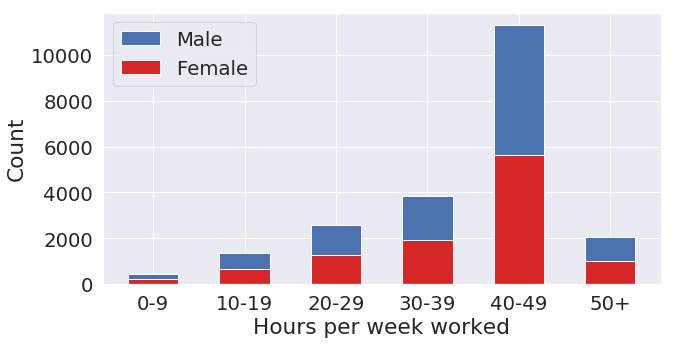

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# plots the bar chart
fig = plt.figure(figsize=(10,5))
sns.set(font_scale=1.8)
categories = ['0-9', '10-19', '20-29', '30-39', '40-49', '50+']
p1 = plt.bar(categories, malecount, 0.55, color = '#d62728')
p2 = plt.bar(categories, femalecount, 0.55, bottom = malecount)
plt.legend((p2[0], p1[0]), ('Male', 'Female'))
plt.xlabel('Hours per week worked')
plt.ylabel('Count')
plt.show()

In [22]:
# Get row sums
# values are the same as in the margins

row_sums = contingency_table.iloc[0:2,6].values
column_sums = contingency_table.iloc[2, 0:6].values

print(row_sums)
print(column_sums)

[10771 21790]
[  458  1246  2392  3667 18336  6462]


In [23]:
# totaltotal value
total = contingency_table.loc['All', 'All']
total 

32561

In [24]:
#  create a 2D numpy array
# looping through the row and column margins and calculating the values and adding the rows to the expected array
expected = []
for i in range (len(row_sums)):
  expected_row=[]
  for column in column_sums:
    expected_val = column*row_sums[1]/total
    expected_row.append(expected_val)
  expected.append(expected_row)

print(np.array(expected))

[[  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


In [25]:
# crosstab without the margins
observed = pd.crosstab(df['sex'], df['hours_per_week_categories']).values
observed

array([[  235,   671,  1287,  1914,  5636,  1028],
       [  223,   575,  1105,  1753, 12700,  5434]])

In [26]:
chi_squared = ((observed - expected)**2/(expected)).sum()
print(f'Chi_Squared: {chi_squared}') 
# with 6 degrees of freedom these values are related becaue p value is miniscule

Chi_Squared: 7085.386054301224


In [27]:
# calculate degrees of freedom
dof = (len(row_sums)-1)*(len(column_sums)-1)
print(f'Degrees of Freedon: {dof}')


Degrees of Freedon: 5


In [28]:
# something from scipy that will do all of this for us
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)
print(f'Chi-Squared: {chi_squared}')
print(f'P-Value: {p_value}')
print(f'Degrees of Freedom: {dof}')
print(f'Expected: \n', np.array(expected))

Chi-Squared: 2287.190943926107
P-Value: 0.0
Degrees of Freedom: 5
Expected: 
 [[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


#confidence interval example

In [29]:
# confidence level = [lower_bound, upper_bound]
coinflips = np.random.binomial(n=1, p=.5, size=100)
print(coinflips)

[1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1
 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1
 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0]


In [30]:
coinflips.mean()

0.53

In [31]:
stats.ttest_1samp(coinflips, .5)
# p-value is high we reject the null hypothesis

Ttest_1sampResult(statistic=0.5980699588110716, pvalue=0.5511590111236772)

##confidence level should get smaller around the mean with a bigger sample size

In [32]:
coinflips_100 = np.random.binomial(n=1, p=.5, size=100)
coinflips_1000 = np.random.binomial(n=1, p=.5, size=1000)

print('100 Mean:', coinflips_100.mean())
print('1000 Mean:', coinflips_1000.mean())

print('100 Coinflips Standard Deviation:', np.std(coinflips_100))
print('1000 Coinflips Standard Deviation:', np.std(coinflips_1000))


100 Mean: 0.41
1000 Mean: 0.481
100 Coinflips Standard Deviation: 0.4918333050943175
1000 Coinflips Standard Deviation: 0.49963886958482323


In [33]:
print('100 Coinflips Standard Error:', stats.sem(coinflips_100))
print('1000 Coinflips Standard Error:', stats.sem(coinflips_1000))

100 Coinflips Standard Error: 0.04943110704237103
1000 Coinflips Standard Error: 0.015807874268505835


In [34]:
# the standard deviation divided by the sq root of the degrees of freedom = standard error
0.49839743177508444/np.sqrt(100-1)

0.05009082659620331

In [35]:
# the standard deviation divided by the sq root of the degrees of freedom = standard error
0.4995588053472784/np.sqrt(1000-1)

0.015805341148131185

In [0]:
# Confidence intervals!
# Similar to hypothesis testing, but centered at sample mean
# Generally better than reporting the "point estimate" (sample mean)
# Why? Because point estimates aren't always perfect

import numpy as np
from scipy import stats

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

def report_confidence_interval(confidence_interval):
  """
  Return a string with a pretty report of a confidence interval.
  
  Arguments:
    confidence_interval - tuple of (mean, lower bound, upper bound)
  
  Returns:
    None, but prints to screen the report
  """
  print('Mean: {}'.format(confidence_interval[0]))
  print('Lower bound: {}'.format(confidence_interval[1]))
  print('Upper bound: {}'.format(confidence_interval[2]))
  s = "our mean lies in the interval [{:.5}, {:.5}]".format(
      confidence_interval[1], confidence_interval[2])
  return s

In [37]:
# 95% confidence level
report_confidence_interval(confidence_interval(coinflips_100))

Mean: 0.41
Lower bound: 0.31191795947468715
Upper bound: 0.5080820405253128


'our mean lies in the interval [0.31192, 0.50808]'

In [38]:
report_confidence_interval(confidence_interval(coinflips_1000))

Mean: 0.481
Lower bound: 0.4499795529105264
Upper bound: 0.5120204470894736


'our mean lies in the interval [0.44998, 0.51202]'

In [39]:
stats.t.ppf(0.05, 5) # p-value, dof

-2.0150483726691575

In [40]:
coinflips_1M = np.random.binomial(n=1, p=.5, size=1000000)
report_confidence_interval(confidence_interval(coinflips_1M))

Mean: 0.499616
Lower bound: 0.4986360166206088
Upper bound: 0.5005959833793913


'our mean lies in the interval [0.49864, 0.5006]'

In [0]:
import pandas as pd
import numpy as np


In [42]:
bills = ['party', 'handicapped-infants', 'water-project-cost-sharing', 
         'adoption-of-the-budget-resolution', 'physician-fee-freeze', 
         'el-salvador-aid', 'religious-groups-in-schools', 
         'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile', 
         'immigration', 'synfuels-corporation-cutback', 'education-spending', 
         'superfund-right-to-sue', 'crime', 'duty-free-exports', 
         'export-administration-act-south-africa']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', names = bills)
df = df.replace({'y': 1, 'n': 0, '?': np.NaN})
df.head()


,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [43]:
rep = df[df['party'] == 'republican']

dem = df[df['party'] == 'democrat'] 
rep.head()

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0


In [64]:
# testing for 0 dem support returns a tiny p-value which would mean you
# REJECT the hypothesis that there is NO dem support

stats.ttest_1samp(dem['handicapped-infants'], 0, nan_policy='omit')

Ttest_1sampResult(statistic=19.825711173357988, pvalue=1.0391992873567661e-53)

In [67]:
# null hypothesis that Democrats neither support nor oppose the issue
stats.ttest_1samp(dem['handicapped-infants'], .5, nan_policy='omit')

Ttest_1sampResult(statistic=3.431373087696574, pvalue=0.000699612317167372)

In [73]:
dem.apply(pd.Series.value_counts).T

,0.0,1.0,democrat
party,NaN,NaN,267.0
handicapped-infants,102.0,156.0,NaN
water-project-cost-sharing,119.0,120.0,NaN
adoption-of-the-budget-resolution,29.0,231.0,NaN
physician-fee-freeze,245.0,14.0,NaN
el-salvador-aid,200.0,55.0,NaN
religious-groups-in-schools,135.0,123.0,NaN
anti-satellite-test-ban,59.0,200.0,NaN
aid-to-nicaraguan-contras,45.0,218.0,NaN
mx-missile,60.0,188.0,NaN


In [75]:
rep.apply(pd.Series.value_counts).T

,0.0,1.0,republican
party,NaN,NaN,168.0
handicapped-infants,134.0,31.0,NaN
water-project-cost-sharing,73.0,75.0,NaN
adoption-of-the-budget-resolution,142.0,22.0,NaN
physician-fee-freeze,2.0,163.0,NaN
el-salvador-aid,8.0,157.0,NaN
religious-groups-in-schools,17.0,149.0,NaN
anti-satellite-test-ban,123.0,39.0,NaN
aid-to-nicaraguan-contras,133.0,24.0,NaN
mx-missile,146.0,19.0,NaN


In [74]:
df.apply(pd.Series.value_counts).T

,0.0,1.0,democrat,republican
party,NaN,NaN,267.0,168.0
handicapped-infants,236.0,187.0,NaN,NaN
water-project-cost-sharing,192.0,195.0,NaN,NaN
adoption-of-the-budget-resolution,171.0,253.0,NaN,NaN
physician-fee-freeze,247.0,177.0,NaN,NaN
el-salvador-aid,208.0,212.0,NaN,NaN
religious-groups-in-schools,152.0,272.0,NaN,NaN
anti-satellite-test-ban,182.0,239.0,NaN,NaN
aid-to-nicaraguan-contras,178.0,242.0,NaN,NaN
mx-missile,206.0,207.0,NaN,NaN


In [76]:
stats.ttest_1samp(df['mx-missile'], .5, nan_policy='omit')

Ttest_1sampResult(statistic=0.049147318718299554, pvalue=0.9608257103188511)

we FAIL TO REJECT the null hypothesis that congressional support for the 'mx-missile' policy is split (even) among all of congress

In [46]:
plot_values = confidence_interval(dem['immigration'])
plot_values

(nan, nan, nan)

In [0]:
bill1 = ['handicapped-infants']
barmean = plot_values[0]
xerror = plot_values[1]
yerror = plot_values[2]  
x_pos = np.arange(len(bill1))

In [0]:
fig, ax = plt.subplots()
ax.bar(x_pos, barmean, xerr = xerror, yerr=yerror, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Democratic votes')
ax.set_xticks(x_pos)
ax.set_xticklabels(bill1)
ax.set_title('test with MOE')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [0]:
# calculate confidence interval around the dem handicapped-infants mean
# similar to hypothesis testing, but centered at sample mean
def confidence_interval(data, confidence=0.95):
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n-1)
  return (mean, mean-interval, mean + interval)

In [82]:
def confidence_interval_dataframe(df):
  confidence_intervals = []
  df = df.values.T
  cleaned_df = []
  for col in df:
    cleaned_col = col[~np.isnan(col)]
    confidence_intervals.append(confidence_interval(cleaned_col))
  
  confidence_intervals = pd.DataFrame(confidence_intervals, columns=['mean', 'lower', 'upper'])
  return confidence_intervals

only_votes = dem.drop('party', axis='columns')

confidence_interval_df = confidence_interval_dataframe(only_votes)
confidence_interval_df.head()

,mean,lower,upper
0,0.604651,0.544593,0.664710
1,0.502092,0.438245,0.565939
2,0.888462,0.849944,0.926980
3,0.054054,0.026332,0.081776
4,0.215686,0.164863,0.266509


In [83]:
confidence_interval_df['margin_of_error']= confidence_interval_df['upper'] - confidence_interval_df['mean']

print(confidence_interval_df.shape)
confidence_interval_df.head()

(16, 4)


,mean,lower,upper,margin_of_error
0,0.604651,0.544593,0.664710,0.060058
1,0.502092,0.438245,0.565939,0.063847
2,0.888462,0.849944,0.926980,0.038518
3,0.054054,0.026332,0.081776,0.027722
4,0.215686,0.164863,0.266509,0.050823


Text(0, 0.5, "Percent of Democrats voting 'yes'")

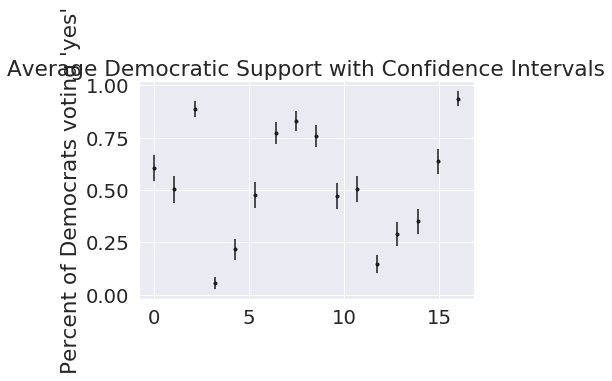

In [85]:
x = np.linspace(0, confidence_interval_df.shape[0], confidence_interval_df.shape[0])
y = confidence_interval_df['mean']
yerr = confidence_interval_df['margin_of_error']

plt.errorbar(x, y, yerr, fmt='.k');
plt.title('Average Democratic Support with Confidence Intervals')
plt.ylabel("Percent of Democrats voting 'yes'")

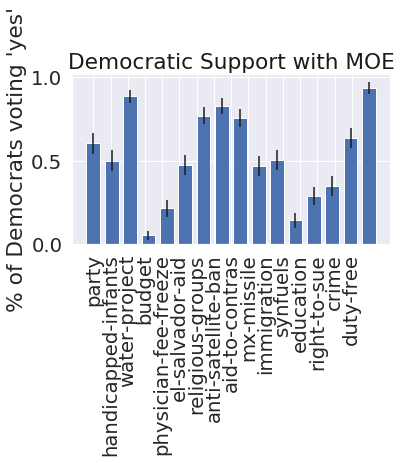

In [86]:
fig, ax = plt.subplots()
means = confidence_interval_df['mean']
error = confidence_interval_df['margin_of_error']
x_pos = np.arange(confidence_interval_df.shape[0])
issues = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']


ax.bar(x, means, yerr=error)
ax.set_ylabel("% of Democrats voting 'yes'")
ax.set_xticks(x_pos)
ax.set_xticklabels(issues)
ax.set_title('Democratic Support with MOE', color='k')
ax.yaxis.grid(True)

# Save the figure and show
# Different style sheets: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.xticks(rotation=90)
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)